In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
import time

%matplotlib inline
import matplotlib.pyplot as plt

Считываем вход из файлов и преобразуем в DataFrame. Кроме того, если необходимо выполнить преобразование входа, можно передать соответствующую трансформирующую функцию *map_f*

In [2]:
INPUT_PATH = './input/'

storage = {}

def read_base(N, map_f=None):
    global storage
    dataset = storage.get(N)
    c_type = 'mapped' if map_f else 'raw'
    if dataset:
        if dataset.get(c_type):
            print 'found cached data...'
            return dataset[c_type]
    else:
        storage[N] = dict()
    print 'reading data from source...'
    LINES = 10**6
    path = '{}Base{}.txt'.format(INPUT_PATH, N)
    X, y = [], []
    with open(path, 'r') as fin:
        for l in tqdm(fin.readlines()):
            x = l.split()[0]
            if map_f:
                X.append(map_f(x))
            else:
                X.append(list(x))
            y.append(l.split()[1])
    print 'converting to dataframe...'
    storage[N][c_type] = (pd.DataFrame(X, dtype=int), pd.Series(y, dtype=int))
    return storage[N][c_type]

Убедимся, что данные выглядят так, как надо:

In [3]:
X, y = read_base(8)
print X.shape, y.shape
print X[:5]
print y[:5]

  3%|▎         | 33464/1000000 [00:00<00:02, 334392.37it/s]

reading data from source...


100%|██████████| 1000000/1000000 [00:02<00:00, 359767.49it/s]


converting to dataframe...
(1000000, 8) (1000000,)
   0  1  2  3  4  5  6  7
0  1  0  0  0  1  0  0  1
1  0  0  1  0  1  0  1  1
2  1  1  1  1  1  0  1  1
3  1  0  1  0  1  0  1  1
4  1  0  1  1  0  0  0  0
0    0
1    0
2    1
3    1
4    1
dtype: int64


Определим функцию обучения для определенного классификатора. Предпочтение в разделение исходной выборки на train/test был отдан методу *train_test_split*, поскольку  *KFold* не имеет смысла, поскольку, например для *LogisticRegression*:

```warm_start : bool, default: False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. Useless for liblinear solver.```

Кроме того, будем выводить **confusion_matrix** для каждого результата обучения, а также метрику **accuracy** (*model.score*)

In [4]:
def learn(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
#     kf = KFold(n_splits=5)
#     for train_index, test_index in kf.split(X):
#         X_train, X_test = X.loc[train_index, :], X.loc[test_index, :]
#         y_train, y_test = y[train_index], y[test_index]
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         cm = confusion_matrix(y_test, y_pred)
    print
    print cm
    score = model.score(X_test, y_test)
    print score
    return score

Здесь выполним трансформирующую функцию для входа. Помимо считанных значений из файла, попробуем добавить в качестве характеристик следующие параметры: посчитаем для каждого *i* переключателя характер распространения сигнала на нем, а именно, поменялись ли в итоге каналами сигналы или нет. Другими словами, если количество *1* четно до *i* блока, то сигналы идут по тем же каналам, как и были запущены из истока, иначе нет. Это достигается поэлементным ксором переключателей. Точно так же сделаем и для блоков, начиная с выхода (в обратном направлении)

In [5]:
def try_map(x):
    all_xor = reduce(lambda kum, v: kum ^ int(v), x, 0)
    res = list(x)
    res.append(all_xor)
    cur_xor = all_xor
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    cur_xor = 0
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    return res

Проверим работоспособность с логистической регрессией на небольшом входе:

In [6]:
model = LogisticRegression(n_jobs=-1, random_state=6)
X, y = read_base(8, try_map)
print 'finished reading input...'
learn(X, y, model)

  0%|          | 3644/1000000 [00:00<00:28, 35193.09it/s]

reading data from source...


100%|██████████| 1000000/1000000 [00:20<00:00, 48386.93it/s]


converting to dataframe...
finished reading input...

[[ 81460      0]
 [     0 118540]]
1.0


1.0

Определим функцию для сравнения результатов обучения без применения т.н. "feature engineering" и вместе с ним:

In [7]:
def try_both(N, model):
    X, y = read_base(N)
    learn(X, y, model)
    
    X, y = read_base(N, try_map)
    learn(X, y, model)

Выполним обучение для всех возможных *BaseN* с выбранной моделью, параллельно насчитывая время, затраченное на чтение/обучение:

In [8]:
def check_all_N(model, N_from=8, N_to=130):
    scores = []
    Ns = range(N_from, N_to, 8)
    
    def run(N):
        print 'running with map for N={}'.format(N)
        X, y = read_base(N, try_map)
        return learn(X, y, model)
    
    for N in Ns:
        st = time.clock()
        scores.append(run(N))
        print time.clock() - st

    plt.figure(figsize=(16, 7))
    plt.plot(Ns, scores)
    plt.title('Score')
    plt.xlabel('N')
    plt.ylabel('Score')
    plt.show()

Запустим логистическую регрессию:

running with map for N=8
found cached data...


  0%|          | 0/1000000 [00:00<?, ?it/s]


[[ 81460      0]
 [     0 118540]]
1.0
4.562974
running with map for N=16
reading data from source...


100%|██████████| 1000000/1000000 [00:41<00:00, 24151.01it/s]


converting to dataframe...


  0%|          | 0/1000000 [00:00<?, ?it/s]


[[ 96281    198]
 [   433 103088]]
0.996845
72.034826
running with map for N=24
reading data from source...


100%|██████████| 1000000/1000000 [00:55<00:00, 17933.98it/s]


converting to dataframe...

[[99541   449]
 [  536 99474]]
0.995075
97.26631
running with map for N=32
reading data from source...


100%|██████████| 1000000/1000000 [01:09<00:00, 14447.43it/s]


converting to dataframe...

[[ 89447    591]
 [   521 109441]]
0.99444
125.942369
running with map for N=40
reading data from source...


100%|██████████| 1000000/1000000 [01:27<00:00, 11489.20it/s]


converting to dataframe...

[[ 91149    574]
 [   581 107696]]
0.994225

  0%|          | 0/1000000 [00:00<?, ?it/s]


155.104923
running with map for N=48
reading data from source...


100%|██████████| 1000000/1000000 [01:43<00:00, 9662.67it/s]


converting to dataframe...

[[103040    573]
 [   601  95786]]
0.99413


  0%|          | 0/1000000 [00:00<?, ?it/s]

187.811405
running with map for N=56
reading data from source...


100%|██████████| 1000000/1000000 [01:58<00:00, 8462.32it/s]


converting to dataframe...

[[ 88050    609]
 [   636 110705]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.993775
227.086726
running with map for N=64
reading data from source...


100%|██████████| 1000000/1000000 [02:12<00:00, 7565.81it/s]


converting to dataframe...

[[ 96694    637]
 [   609 102060]]


  0%|          | 0/1000000 [00:00<?, ?it/s]

0.99377
257.827048
running with map for N=72
reading data from source...


100%|██████████| 1000000/1000000 [02:27<00:00, 6759.27it/s]


converting to dataframe...

[[ 92839    623]
 [   682 105856]]
0.993475
289.589804
running with map for N=80
reading data from source...


100%|██████████| 1000000/1000000 [02:41<00:00, 6181.81it/s]


converting to dataframe...

[[98861   698]
 [  628 99813]]
0.99337
317.225066
running with map for N=88
reading data from source...


100%|██████████| 1000000/1000000 [02:59<00:00, 5575.85it/s]


converting to dataframe...

[[ 91666    695]
 [   707 106932]]
0.99299
364.141426
running with map for N=96
reading data from source...


100%|██████████| 1000000/1000000 [03:28<00:00, 4790.43it/s]


converting to dataframe...

[[99637   744]
 [  843 98776]]
0.992065
408.996336
running with map for N=104
reading data from source...


100%|██████████| 1000000/1000000 [03:40<00:00, 4532.68it/s]


converting to dataframe...

[[ 85768    812]
 [   799 112621]]
0.991945
438.198531
running with map for N=112
reading data from source...


100%|██████████| 1000000/1000000 [04:11<00:00, 3971.53it/s]


converting to dataframe...

[[ 93418    806]
 [   853 104923]]
0.991705
482.270714
running with map for N=120
reading data from source...


100%|██████████| 1000000/1000000 [04:21<00:00, 3824.66it/s]


converting to dataframe...

[[ 92996    781]
 [   871 105352]]
0.99174
518.453674
running with map for N=128
reading data from source...


100%|██████████| 1000000/1000000 [04:28<00:00, 3730.73it/s]


converting to dataframe...

[[ 75917    863]
 [   838 122382]]
0.991495
538.360994


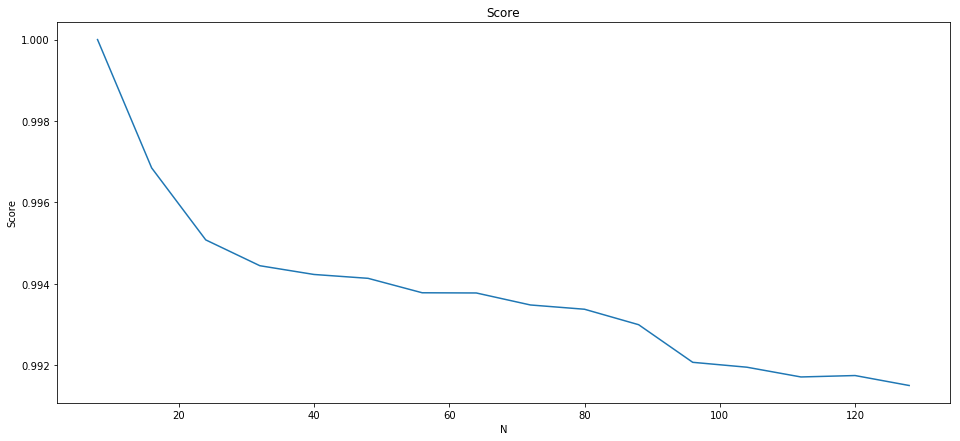

In [9]:
model = LogisticRegression(n_jobs=-1, random_state=6)
check_all_N(model)

Запустим KNN:

In [ ]:
model = KNeighborsClassifier(n_jobs=-1, n_neighbors=32)
X, y = read_base(16, try_map)
learn(X, y, model)

found cached data...


Попробуем сходимость SVM классификатора на небольшом входе:

In [10]:
model = LinearSVC(max_iter=10000, random_state=6, verbose=5)
try_both(16, model)

  0%|          | 0/1000000 [00:00<?, ?it/s]

reading data from source...


100%|██████████| 1000000/1000000 [00:03<00:00, 295846.77it/s]


converting to dataframe...
[LibLinear]
[[59675 36804]
 [40623 62898]]
0.612865
found cached data...
[LibLinear]
[[ 96247    232]
 [   367 103154]]
0.997005


И запустим его для больших *BaseN* ($N >= 96$), чтобы сэкономить время:

running with map for N=96
found cached data...
[LibLinear]
[[99634   747]
 [  830 98789]]
0.992115
154.833477
running with map for N=104
found cached data...
[LibLinear]
[[ 85786    794]
 [   786 112634]]
0.9921
175.556763
running with map for N=112
found cached data...
[LibLinear]
[[ 93427    797]
 [   822 104954]]
0.991905
194.103527
running with map for N=120
found cached data...
[LibLinear]
[[ 93016    761]
 [   848 105375]]
0.991955
203.891302
running with map for N=128
found cached data...
[LibLinear]
[[ 75946    834]
 [   818 122402]]
0.99174
237.141778


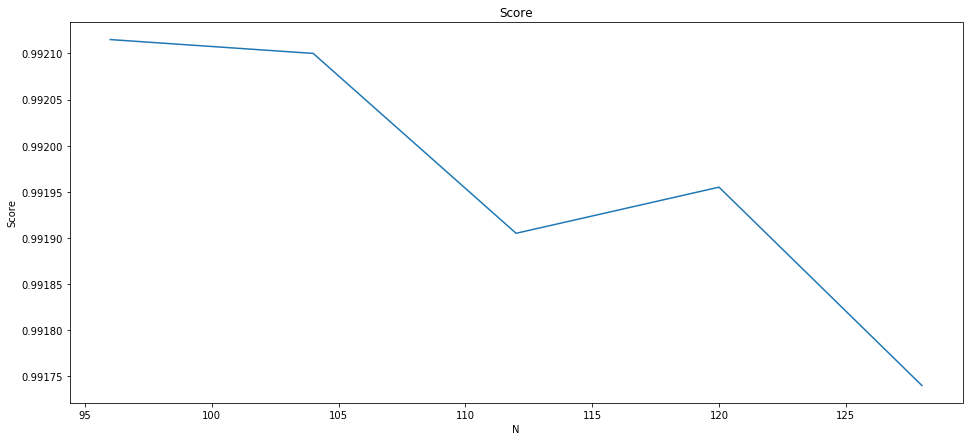

In [11]:
model = LinearSVC(max_iter=10000, random_state=6, verbose=5)
check_all_N(model, N_from=96)

Попробуем использовать деревья решений:

running with map for N=96
found cached data...

[[64957 35424]
 [40917 58702]]
0.618295
113.341505
running with map for N=104
found cached data...

[[51196 35384]
 [41673 71747]]
0.614715
123.251734
running with map for N=112
found cached data...

[[57946 36278]
 [42746 63030]]
0.60488
136.628745
running with map for N=120
found cached data...

[[57409 36368]
 [42801 63422]]
0.604155
147.666415
running with map for N=128
found cached data...

[[41373 35407]
 [42602 80618]]
0.609955
157.755447


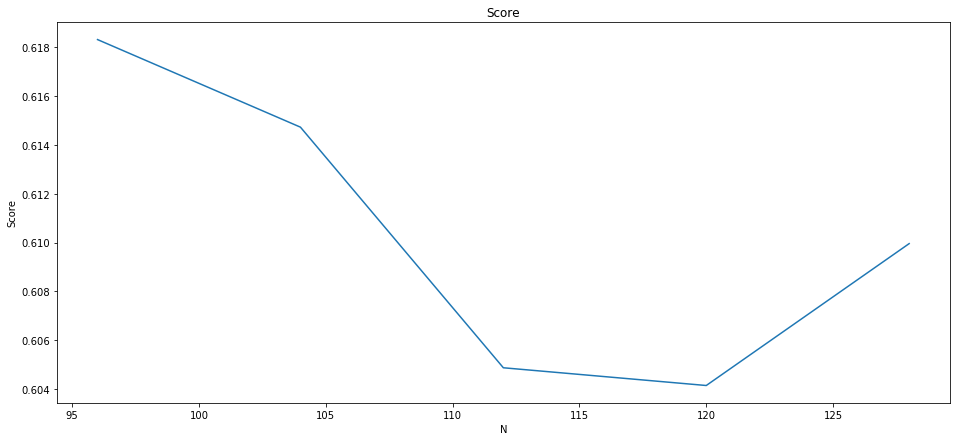

In [12]:
model = DecisionTreeClassifier(min_samples_leaf=4)
check_all_N(model, N_from=96)

In [13]:
def try_subset(X, y, model, percentage):
    part = int(X.shape[0] * percentage / 100.0)
    return learn(X.loc[:part, :], y.loc[:part], model)

In [14]:
def find_part(model, N, thr=0.95, step=10):
    X, y = read_base(N, try_map)
    for pt in np.arange(0.1, 95, step):
        print 'running for', pt
        acc = try_subset(X, y, model, pt)
        if acc >= thr:
            print 'Need', pt, '% data to achieve', thr
            break
    return pt

In [15]:
model = LogisticRegression(n_jobs=-1, random_state=6)
find_part(model, 128)

found cached data...
running for 0.1

[[ 45  27]
 [ 15 114]]
0.791044776119
running for 10.1

[[ 7664   137]
 [  136 12264]]
0.986485817534
Need 10.1 % data to achieve 0.95


10.1

In [16]:
model = LogisticRegression(n_jobs=-1, random_state=6)
find_part(model, 128, step=0.1)

found cached data...
running for 0.1

[[ 45  27]
 [ 15 114]]
0.791044776119
running for 0.2

[[125  23]
 [ 26 227]]
0.877805486284
running for 0.3

[[188  34]
 [ 33 346]]
0.888519134775
running for 0.4

[[260  29]
 [ 38 474]]
0.916354556804
running for 0.5

[[347  28]
 [ 33 593]]
0.939060939061
running for 0.6

[[393  31]
 [ 34 743]]
0.945878434638
running for 0.7

[[463  44]
 [ 31 863]]
0.946466809422
running for 0.8

[[564  42]
 [ 42 953]]
0.947532792005
running for 0.9

[[ 639   38]
 [  43 1081]]
0.955024986119
Need 0.9 % data to achieve 0.95


0.90000000000000002

Попробуем запустить логистическую регрессию на 128-битном входе с используемой ранее трансформацией входа, но при этом **не учитывая первые 128 характеристик**, то есть оставив лишь искусственные ксоры:

In [19]:
def map_without_initial(x):
    all_xor = reduce(lambda kum, v: kum ^ int(v), x, 0)
    res = []
    res.append(all_xor)
    cur_xor = all_xor
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    cur_xor = 0
    for i in x:
        cur_xor ^= int(i)
        res.append(cur_xor)
    return res

model = LogisticRegression(n_jobs=-1, random_state=6)
X, y = read_base(128, map_without_initial)
print 'finished reading input...'
print learn(X, y, model)

found cached data...
finished reading input...

[[ 75917    863]
 [   838 122382]]
0.991495
0.991495


Как видно, результат по-прежнему хорош

# Выводы

В качестве метрики хорошо показывает себя предложенная метрика **Accuracy** (поскольку классификация бинарная). Кроме того, полезно оценить матрицу ошибок, потому что без изменения входа *LogisticRegression* начиная с некоторого *N* везде предсказывала либо чистый *0*, либо чистый *1* (в этом отчете этого не осталось). Это можно было увидеть по матрице ошибок: одна из колонок была полностью нулевая.

Зависимости метрики **Accuracy** от *N* представлены на графиках. Среди реально запущенных классификаторов (*LogisticRegression*, *LinearSVC*, *DecisionTree*) только *DecisionTree* не смогло приблизиться к результатам первых двух и осталось на уровне обычного логистической регрессии на чистом входе. Скорее всего, это обусловлено тем, что деревья решений хорошо работают со значениями характеристик на интервалах, а здесь значение каждой характеристики бинарно. Это ведет к достаточно глубокому дереву, что, вероятнее всего, ведет к переобучению. 

*KNN* выполнялся слишком долго, так что пришлось его остановить.

Как видно из последних запусков $\approx 0.1\%$ данных достаточно, чтобы получить 0.95 accuracy.